 Reference: https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb

In [2]:
import os
import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np 
import cv2
from sklearn.model_selection import train_test_split

import peak_promience2d

from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [3]:
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator


## create a datagenerator 

In [4]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),])
def load_train_img(filename):
    mapName = '/home/shared/DARPA/all_patched_data/training/point/map_patches/'+filename[0]
    legendName = '/home/shared/DARPA/all_patched_data/training/point/legend_converted/'+filename[1]     

    map_img = tf.io.read_file(mapName) # Read image file
    map_img = tf.cast(tf.io.decode_png(map_img), dtype=tf.float32) / 255.0
    
    # edge detection to filter out lines
    kChannel = 1 - tf.reduce_max(map_img, axis=2) # Calculate channel K
    binaryThresh = 40/255
    binaryImage = tf.clip_by_value(kChannel, clip_value_min=binaryThresh, clip_value_max=1) # keep only black pixel
    binaryImage = 2.0*(binaryImage-binaryThresh)/(1.0-binaryThresh)-1.0
    binaryImage = tf.expand_dims(binaryImage, axis=-1)
    
    legend_img = tf.io.read_file(legendName) # Read image file
    legend_img = tf.cast(tf.io.decode_png(legend_img), dtype=tf.float32) / 255.0
    
    augmented_img = data_augmentation(legend_img)

    img = tf.concat(axis=2, values = [binaryImage, augmented_img])
    img = img*2.0 - 1.0 # range(-1.0,1.0)
    resize_image = tf.image.resize(img, [256, 256])
    
    segName = '/home/shared/DARPA/all_patched_data/training/point/seg_patches_converted/'+filename[0] 
    seg = tf.io.read_file(segName) # Read image file
    seg = tf.io.decode_png(seg)
    seg = tf.cast(seg, dtype=tf.float32) / 255.0
    seg = tf.image.resize(seg, [256, 256])
    
    return resize_image, seg


2022-11-15 13:22:12.610272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13876 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:04:00.0, compute capability: 7.0


In [72]:
def load_validation_img(filename):
    mapName = '/home/shared/DARPA/all_patched_data/validation/point/map_patches/'+filename[0]
    legendName = '/home/shared/DARPA/all_patched_data/validation/point/legend_converted/'+filename[1]     

    map_img = tf.io.read_file(mapName) # Read image file
    map_img = tf.cast(tf.io.decode_png(map_img), dtype=tf.float32) / 255.0
    
    # edge detection to filter out lines
    kChannel = 1 - tf.reduce_max(map_img, axis=2) # Calculate channel K
    binaryThresh = 40/255
    binaryImage = tf.clip_by_value(kChannel, clip_value_min=binaryThresh, clip_value_max=1) # keep only black pixel
    binaryImage = 2.0*(binaryImage-binaryThresh)/(1.0-binaryThresh)-1.0
    binaryImage = tf.expand_dims(binaryImage, axis=-1)
    
    legend_img = tf.io.read_file(legendName) # Read image file
    legend_img = tf.cast(tf.io.decode_png(legend_img), dtype=tf.float32) / 255.0

    img = tf.concat(axis=2, values = [binaryImage, legend_img])
    img = img*2.0 - 1.0 # range(-1.0,1.0)
    resize_image = tf.image.resize(img, [256, 256])
    
    segName = '/home/shared/DARPA/all_patched_data/validation/point/seg_patches_converted/'+filename[0] 
    seg = tf.io.read_file(segName) # Read image file
    seg = tf.io.decode_png(seg)
    seg = tf.cast(seg, dtype=tf.float32) / 255.0
    seg = tf.image.resize(seg, [256, 256])
    
    return resize_image, seg


In [73]:
train_map_file = os.listdir('/home/shared/DARPA/all_patched_data/training/point/map_patches')
random.shuffle(train_map_file)
train_map_legend_names = [(x, '_'.join(x.split('_')[0:-2])+'.png') for x in train_map_file]

train_dataset = tf.data.Dataset.from_tensor_slices(train_map_legend_names)
train_dataset = train_dataset.map(load_train_img)
train_dataset = train_dataset.shuffle(4000, reshuffle_each_iteration=False).batch(64)

# A peek of how BatchDataset 
# it = iter(train_dataset)
# print(next(it))

validate_map_file = os.listdir('/home/shared/DARPA/all_patched_data/validation/point/map_patches')
validate_map_legend_names = [(x, '_'.join(x.split('_')[0:-2])+'.png') for x in validate_map_file]

validate_dataset = tf.data.Dataset.from_tensor_slices(validate_map_legend_names)
validate_dataset = validate_dataset.map(load_validation_img)
validate_dataset = validate_dataset.batch(50)

## Constructing the U-Net Architecture

### U-Net Encoder Block

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

### U-Net Decoder Block

In [8]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Compile U-Net Blocks

In [9]:
def UNetCompiled(input_size=(256, 256, 4), n_filters=32, n_classes=1):
    """
       Combine both encoder and decoder blocks according to the U-Net research paper
       Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [10]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(256,256,4), n_filters=16, n_classes=1)

### Compile and Run Model

In [10]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss= tf.keras.losses.mae, # tf.keras.losses.binary_crossentropy,  #BinaryFocalCrossentropy(gamma=2.0, from_logits=False), #
              metrics=['accuracy', 'acc'])

In [11]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='./saved_point_model/best_model.hdf5', 
    monitor='loss',
    verbose=1, 
    save_best_only=True,
    save_freq= 100)

In [16]:
# load weights
if os.path.exists("./saved_point_model/best_model.hdf5"):
    unet.load_weights("./saved_point_model/best_model.hdf5")

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(train_dataset, epochs=30, callbacks=[callback1], validation_data=validate_dataset)

Epoch 1/30
 82/392 [=====>........................] - ETA: 3:06 - loss: 0.0912 - accuracy: 9.1093e-05 - acc: 9.1093e-05
Epoch 1: loss improved from 0.09138 to 0.09124, saving model to ./saved_point_model/best_model.hdf5
182/392 [============>.................] - ETA: 1:32 - loss: 0.0910 - accuracy: 9.1713e-05 - acc: 9.1713e-05
Epoch 1: loss improved from 0.09124 to 0.09108, saving model to ./saved_point_model/best_model.hdf5
282/392 [====================>.........] - ETA: 42s - loss: 0.0913 - accuracy: 9.2046e-05 - acc: 9.2046e-05
Epoch 1: loss did not improve from 0.09108
382/392 [============================>.] - ETA: 3s - loss: 0.0913 - accuracy: 9.2137e-05 - acc: 9.2137e-05
Epoch 1: loss did not improve from 0.09108
392/392 [==============================] - 154s 374ms/step - loss: 0.0914 - accuracy: 9.2217e-05 - acc: 9.2217e-05 - val_loss: 0.1154 - val_accuracy: 9.2085e-05 - val_acc: 9.2085e-05
Epoch 2/30
 90/392 [=====>........................] - ETA: 1:28 - loss: 0.0905 - accura

Epoch 10/30
 54/392 [===>..........................] - ETA: 1:39 - loss: 0.0829 - accuracy: 9.1879e-05 - acc: 9.1879e-05
Epoch 10: loss did not improve from 0.08231
154/392 [==========>...................] - ETA: 1:10 - loss: 0.0817 - accuracy: 9.2736e-05 - acc: 9.2736e-05
Epoch 10: loss improved from 0.08231 to 0.08171, saving model to ./saved_point_model/best_model.hdf5
254/392 [==================>...........] - ETA: 40s - loss: 0.0816 - accuracy: 9.3626e-05 - acc: 9.3626e-05
Epoch 10: loss improved from 0.08171 to 0.08157, saving model to ./saved_point_model/best_model.hdf5
354/392 [==========================>...] - ETA: 10s - loss: 0.0815 - accuracy: 9.3530e-05 - acc: 9.3530e-05
Epoch 10: loss improved from 0.08157 to 0.08151, saving model to ./saved_point_model/best_model.hdf5
392/392 [==============================] - 128s 307ms/step - loss: 0.0815 - accuracy: 9.3515e-05 - acc: 9.3515e-05 - val_loss: 0.1162 - val_accuracy: 9.1678e-05 - val_acc: 9.1678e-05
Epoch 11/30
 62/392 [===

392/392 [==============================] - 127s 305ms/step - loss: 0.0729 - accuracy: 9.4306e-05 - acc: 9.4306e-05 - val_loss: 0.1149 - val_accuracy: 9.2679e-05 - val_acc: 9.2679e-05
Epoch 29/30
  6/392 [..............................] - ETA: 1:53 - loss: 0.0709 - accuracy: 9.4334e-05 - acc: 9.4334e-05
Epoch 29: loss improved from 0.07277 to 0.07079, saving model to ./saved_point_model/best_model.hdf5
106/392 [=======>......................] - ETA: 1:24 - loss: 0.0729 - accuracy: 9.3366e-05 - acc: 9.3366e-05
Epoch 29: loss did not improve from 0.07079
206/392 [==============>...............] - ETA: 54s - loss: 0.0728 - accuracy: 9.4004e-05 - acc: 9.4004e-05
Epoch 29: loss did not improve from 0.07079
306/392 [======================>.......] - ETA: 25s - loss: 0.0730 - accuracy: 9.4090e-05 - acc: 9.4090e-05
Epoch 29: loss did not improve from 0.07079
392/392 [==============================] - 127s 305ms/step - loss: 0.0730 - accuracy: 9.4255e-05 - acc: 9.4255e-05 - val_loss: 0.1179 - va

In [ ]:
# serialize and save the model that you just trained 
saved_model_path = "./saved_point_model/my_model.h5" 
unet.save(saved_model_path)

## Evaluate Model Results

### View Predicted Segmentations

In [11]:
unet.load_weights("./saved_point_model/best_model.hdf5")

In [93]:
def plotResult(n, fileName):
    test_dataset = tf.data.Dataset.from_tensor_slices([fileName])
    test_dataset = test_dataset.map(load_validation_img)
    test_dataset = test_dataset.batch(1)

    predicted = unet.predict(test_dataset)
    
    mapName = '/home/shared/DARPA/all_patched_data/validation/point/map_patches/'+fileName[0]
    segName = '/home/shared/DARPA/all_patched_data/validation/point/seg_patches/'+fileName[0]
    seg_converted_Name = '/home/shared/DARPA/all_patched_data/validation/point/seg_patches_converted/'+fileName[0]
    legendName = '/home/shared/DARPA/all_patched_data/validation/point/legend/'+fileName[1]

    map_img = mpimg.imread(mapName)
    seg_img = mpimg.imread(segName)
    seg_converted_img = mpimg.imread(seg_converted_Name)

    label_img = mpimg.imread(legendName)
    
    plt.rcParams["figure.figsize"] = (25,10)
    
    plt.subplot(n,7,1)
    plt.title("map")
    plt.imshow(map_img, cmap='gray')

    plt.subplot(n,7,2)
    plt.title("legend_converted")
    plt.imshow(label_img)

    plt.subplot(n,7,3)
    plt.title("true segmentation")
    plt.spy(seg_img,markersize=5) 
    
    plt.subplot(n,7,4)
    plt.title("true converted segmentation")
    plt.imshow(seg_converted_img) 
    
    total_point = np.sum(seg_img)*256
#     print('True Sum converted: ', np.sum(seg_converted_img))
#     print('Predicted Sum converted: ', np.sum(predicted[0,:,:,0]))
#     print('Total number of point:', total_point)
#     print('Average of true:', np.sum(seg_converted_img)/total_point)
#     print('Average of Predicted:', np.sum(predicted[0,:,:,0])/total_point)
    
    data = np.where(total_point>0.5, predicted[0,:,:,0], 0)
    
    plt.subplot(n,7,5)
    plt.title("predicted coverted segmentation")
    plt.imshow(data)

    
    plt.subplot(n, 7, 6)
#     image_max = ndi.maximum_filter(data, size=30, mode='constant')
    coordinates = peak_local_max(data, min_distance=25, threshold_abs=0.8, exclude_border=False)
    final_raster = np.zeros_like(data)
    for x, y in coordinates:
        final_raster[x][y]= 1
    plt.spy(final_raster,markersize=5)

    xx=np.linspace(0,255,256)
    yy=np.linspace(0,255,256)
    
    _, _, result_map, _ = peak_promience2d.getProminence(data,0.5,lats=yy,lons=xx,min_area=None,include_edge=True)
    
    plt.subplot(n, 7, 7)
    plt.spy(result_map,markersize=5)
    

    plt.show()

('AZ_Clifton_314492_1962_62500_geo_mosaic_4_pt_14_16.png', 'AZ_Clifton_314492_1962_62500_geo_mosaic_4_pt.png')


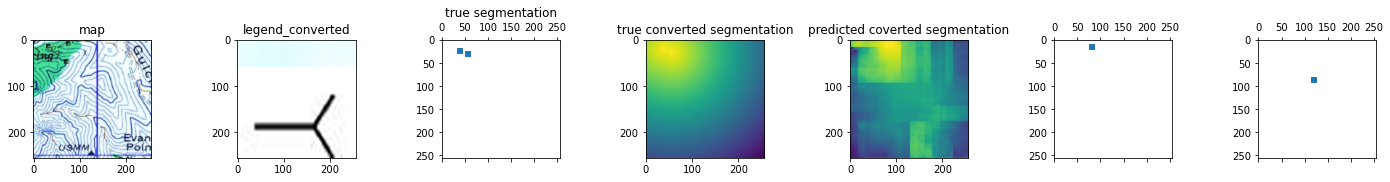

('NM_SantaRita_192296_1951_24000_geo_mosaic_5_pt_8_11.png', 'NM_SantaRita_192296_1951_24000_geo_mosaic_5_pt.png')


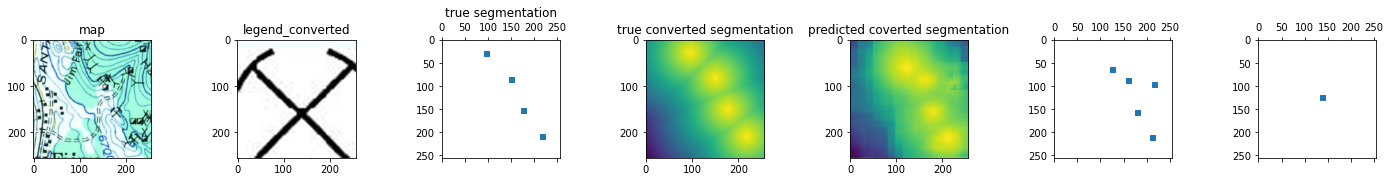

('NV_Rawhide_319871_1980_24000_geo_mosaic_3_pt_22_15.png', 'NV_Rawhide_319871_1980_24000_geo_mosaic_3_pt.png')


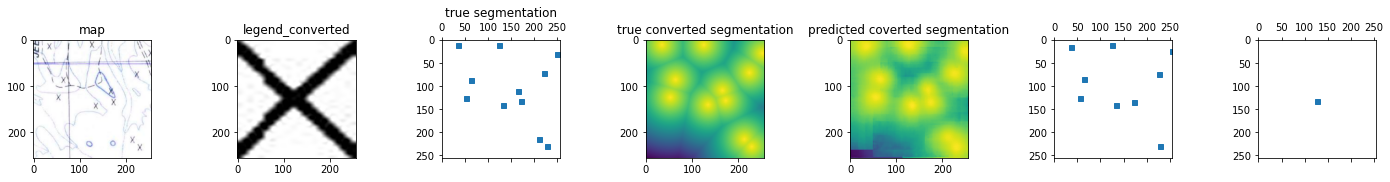

('AR_Maumee_inclined_pt_8_14.png', 'AR_Maumee_inclined_pt.png')


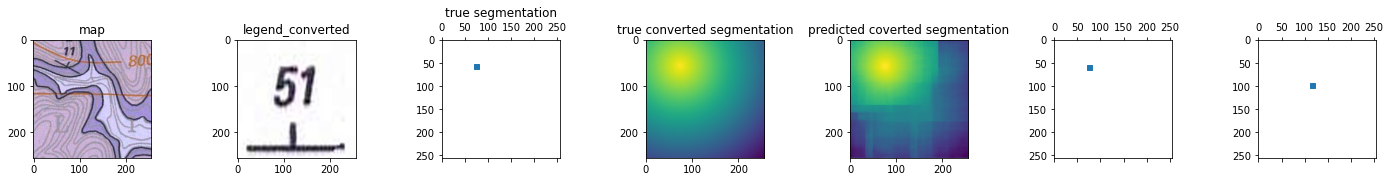

In [94]:
n=4
for fileName in random.sample(validate_map_legend_names, n):
    print(fileName)
    plotResult(n, fileName)